In [1]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'svg'

## Import module

In [2]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import torch
import os
from torchsummary import summary
from torchvision import transforms                                                                                                                                        
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.metrics import accuracy_score
mpl.rcParams['figure.dpi'] = 600
from PIL import Image

import sys
sys.path.append("../../../src/")
sys.path.append("../..")
import model
from datasets import imagenet
import config
from aux.utils import obtain_features_map, load_imgs, zscore, extract_valid
from aux.visualization import visualize_features_map
from utils.function import recreate_image                                                                                                                                       

## Hyperparameter

In [3]:
resume = "037-0"
model_dir = "/home/lincolnzjx/Desktop/Interpretation/saved/models"
generated_dir = "/home/lincolnzjx/Desktop/saved/generated/"
backbone = "vgg16"

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Load modal from dict

In [4]:
# model
net = model.Network(backbone=backbone, num_classes=1000)
net.to(device)

# resume from model
resume_exp = resume.split("-")[0]
resume_epoch = resume.split("-")[1]
print("Resume from model from exp: {} at epoch {}".format(resume_exp, resume_epoch))
resume_path = os.path.join(model_dir, str(resume_exp), str(resume_epoch))
ckpt = torch.load(resume_path, map_location=device)
net.load_state_dict(ckpt) 

# Class & data
class_index = 975
batch_size = 256
num_workers = 4
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
reverse_mean = [-0.485, -0.456, -0.406]
reverse_std = [1/0.229, 1/0.224, 1/0.225]

> Use original fc
Resume from model from exp: 037 at epoch 0


## Load Original Data 

In [5]:
# Load data
train_transform = transforms.Compose([                                                                                                                                
    transforms.Resize((224, 224), interpolation=Image.BILINEAR),                                                                                              
    transforms.ToTensor(),                                                                                                                                            
    transforms.Normalize(mean, std)                                                                                                                                   
       ])         
trainset = imagenet.ImageNet(root="/media/lincolnzjx/HardDisk/Datasets/", 
                             is_train=True, transform=train_transform)

### Get 950 category all images 

In [6]:
len_specific_category = len(trainset.targets_imgs_dict[class_index])
print(len_specific_category)
trainset.set_data([class_index], len_specific_category)

trainloader = torch.utils.data.DataLoader(trainset,
                                          batch_size=batch_size,
                                          shuffle=False,
                                          num_workers=num_workers,
                                          pin_memory=True)

1300
Len of new dataset is :1300


In [7]:
y_true = []
y_pred = []

net.eval()
with torch.no_grad():
    for index, (data, target, *_) in enumerate(trainloader):
        data = data.to(device)
        predict = torch.argmax(net(data), dim=1).cpu().data.numpy()
        y_pred.extend(predict)
        target = target.cpu().data.numpy()
        y_true.extend(target)

In [8]:
acc = accuracy_score(y_true, y_pred)
print("Acc ", acc)

Acc  0.6076923076923076


(-0.5, 223.5, 223.5, -0.5)

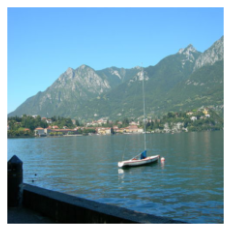

In [9]:
example_img = data[0].cpu().numpy()
example_img_re = recreate_image(example_img, reverse_mean, reverse_std)
plt.imshow(example_img_re)
plt.axis("off")

## Load Gray Image

In [10]:
# Load data
train_transform = transforms.Compose([                                                                                                                                
    transforms.Resize((224, 224), interpolation=Image.BILINEAR),                                                                                              
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),                                                                                                                                            
    transforms.Normalize(mean, std)                                                                                                                                   
       ])         
trainset = imagenet.ImageNet(root="/media/lincolnzjx/HardDisk/Datasets/", 
                             is_train=True, transform=train_transform)

In [11]:
len_specific_category = len(trainset.targets_imgs_dict[class_index])
print(len_specific_category)
trainset.set_data([class_index], len_specific_category)

trainloader = torch.utils.data.DataLoader(trainset,
                                          batch_size=batch_size,
                                          shuffle=False,
                                          num_workers=num_workers,
                                          pin_memory=True)

1300
Len of new dataset is :1300


In [12]:
y_true = []
y_pred = []

net.eval()
with torch.no_grad():
    for index, (data, target, img_path) in enumerate(trainloader):
        # rgb to bgr
        data = data.to(device)
        
        predict = torch.argmax(net(data), dim=1).cpu().data.numpy()
        y_pred.extend(predict)
        target = target.cpu().data.numpy()
        y_true.extend(target)

In [13]:
acc = accuracy_score(y_true, y_pred)
print("Gray Acc ", acc)

Gray Acc  0.36230769230769233


(-0.5, 223.5, 223.5, -0.5)

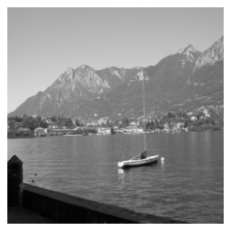

In [14]:
example_img = data[0].cpu().numpy()
example_img_re = recreate_image(example_img, reverse_mean, reverse_std)
plt.imshow(example_img_re)
plt.axis("off")

## Load Swap, RGB->BGR

In [15]:
# Load data
train_transform = transforms.Compose([                                                                                                                                
    transforms.Resize((224, 224), interpolation=Image.BILINEAR),                                                                                              
    transforms.ToTensor(),                                                                                                                                            
    transforms.Normalize(mean, std)                                                                                                                                   
       ])         
trainset = imagenet.ImageNet(root="/media/lincolnzjx/HardDisk/Datasets/", 
                             is_train=True, transform=train_transform)

In [16]:
len_specific_category = len(trainset.targets_imgs_dict[class_index])
print(len_specific_category)
trainset.set_data([class_index], len_specific_category)

trainloader = torch.utils.data.DataLoader(trainset,
                                          batch_size=batch_size,
                                          shuffle=False,
                                          num_workers=num_workers,
                                          pin_memory=True)

1300
Len of new dataset is :1300


In [17]:
y_true = []
y_pred = []

net.eval()
with torch.no_grad():
    for index, (data, target, *_) in enumerate(trainloader):
        # rgb to bgr
        data = data[:,[2, 1, 0]]
        data = data.to(device)
        
        predict = torch.argmax(net(data), dim=1).cpu().data.numpy()
        y_pred.extend(predict)
        target = target.cpu().data.numpy()
        y_true.extend(target)

In [18]:
acc = accuracy_score(y_true, y_pred)
print("BGR Acc ", acc)

BGR Acc  0.3392307692307692


(-0.5, 223.5, 223.5, -0.5)

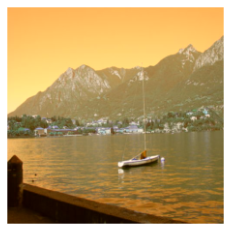

In [19]:
example_img = data[0].cpu().numpy()
example_img_re = recreate_image(example_img, reverse_mean, reverse_std)
plt.imshow(example_img_re)
plt.axis("off")

## Load Swap, RGB->RBG

In [20]:
# Load data
train_transform = transforms.Compose([                                                                                                                                
    transforms.Resize((224, 224), interpolation=Image.BILINEAR),                                                                                              
    transforms.ToTensor(),                                                                                                                                            
    transforms.Normalize(mean, std)                                                                                                                                   
       ])         
trainset = imagenet.ImageNet(root="/media/lincolnzjx/HardDisk/Datasets/", 
                             is_train=True, transform=train_transform)

In [21]:
len_specific_category = len(trainset.targets_imgs_dict[class_index])
print(len_specific_category)
trainset.set_data([class_index], len_specific_category)

trainloader = torch.utils.data.DataLoader(trainset,
                                          batch_size=batch_size,
                                          shuffle=False,
                                          num_workers=num_workers,
                                          pin_memory=True)

1300
Len of new dataset is :1300


In [22]:
y_true = []
y_pred = []

net.eval()
with torch.no_grad():
    for index, (data, target, *_) in enumerate(trainloader):
        # rgb to bgr
        data = data[:,[0, 2, 1]]
        data = data.to(device)
        
        predict = torch.argmax(net(data), dim=1).cpu().data.numpy()
        y_pred.extend(predict)
        target = target.cpu().data.numpy()
        y_true.extend(target)

In [23]:
acc = accuracy_score(y_true, y_pred)
print(" Acc RBG", acc)

 Acc RBG 0.5561538461538461


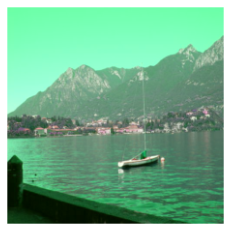

In [24]:
example_img = data[0].cpu().numpy()
example_img_re = recreate_image(example_img, reverse_mean, reverse_std)
plt.axis("off")
plt.imshow(example_img_re)

## Load Swap, RGB->BRG

In [25]:
# Load data
train_transform = transforms.Compose([                                                                                                                                
    transforms.Resize((224, 224), interpolation=Image.BILINEAR),                                                                                              
    transforms.ToTensor(),                                                                                                                                            
    transforms.Normalize(mean, std)                                                                                                                                   
       ])         
trainset = imagenet.ImageNet(root="/media/lincolnzjx/HardDisk/Datasets/", 
                             is_train=True, transform=train_transform)

In [26]:
len_specific_category = len(trainset.targets_imgs_dict[class_index])
print(len_specific_category)
trainset.set_data([class_index], len_specific_category)

trainloader = torch.utils.data.DataLoader(trainset,
                                          batch_size=batch_size,
                                          shuffle=False,
                                          num_workers=num_workers,
                                          pin_memory=True)

1300
Len of new dataset is :1300


In [27]:
y_true = []
y_pred = []

net.eval()
with torch.no_grad():
    for index, (data, target, *_) in enumerate(trainloader):
        # rgb to bgr
        data = data[:,[2, 0, 1]]
        data = data.to(device)
        
        predict = torch.argmax(net(data), dim=1).cpu().data.numpy()
        y_pred.extend(predict)
        target = target.cpu().data.numpy()
        y_true.extend(target)

In [28]:
acc = accuracy_score(y_true, y_pred)
print("BRG Acc ", acc)

BRG Acc  0.3853846153846154


(-0.5, 223.5, 223.5, -0.5)

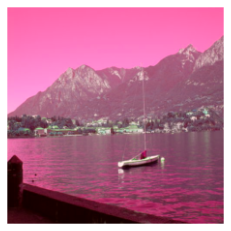

In [29]:
example_img = data[0].cpu().numpy()
example_img_re = recreate_image(example_img, reverse_mean, reverse_std)
plt.imshow(example_img_re)
plt.axis("off")

## Load Swap, RGB->GBR

In [30]:
# Load data
train_transform = transforms.Compose([                                                                                                                                
    transforms.Resize((224, 224), interpolation=Image.BILINEAR),                                                                                              
    transforms.ToTensor(),                                                                                                                                            
    transforms.Normalize(mean, std)                                                                                                                                   
       ])         
trainset = imagenet.ImageNet(root="/media/lincolnzjx/HardDisk/Datasets/", 
                             is_train=True, transform=train_transform)

In [31]:
len_specific_category = len(trainset.targets_imgs_dict[class_index])
print(len_specific_category)
trainset.set_data([class_index], len_specific_category)

trainloader = torch.utils.data.DataLoader(trainset,
                                          batch_size=batch_size,
                                          shuffle=False,
                                          num_workers=num_workers,
                                          pin_memory=True)

1300
Len of new dataset is :1300


In [32]:
y_true = []
y_pred = []

net.eval()
with torch.no_grad():
    for index, (data, target, *_) in enumerate(trainloader):
        # rgb to bgr
        data = data[:,[1, 2, 0]]
        data = data.to(device)
        
        predict = torch.argmax(net(data), dim=1).cpu().data.numpy()
        y_pred.extend(predict)
        target = target.cpu().data.numpy()
        y_true.extend(target)

In [33]:
acc = accuracy_score(y_true, y_pred)
print("GBR Acc ", acc)

GBR Acc  0.5192307692307693


(-0.5, 223.5, 223.5, -0.5)

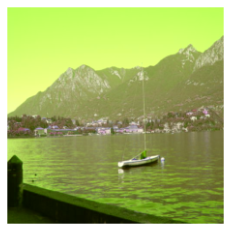

In [34]:
example_img = data[0].cpu().numpy()
example_img_re = recreate_image(example_img, reverse_mean, reverse_std)
plt.imshow(example_img_re)
plt.axis("off")

## Load Swap, RGB->GRB

In [35]:
# Load data
train_transform = transforms.Compose([                                                                                                                                
    transforms.Resize((224, 224), interpolation=Image.BILINEAR),                                                                                              
    transforms.ToTensor(),                                                                                                                                            
    transforms.Normalize(mean, std)                                                                                                                                   
       ])         
trainset = imagenet.ImageNet(root="/media/lincolnzjx/HardDisk/Datasets/", 
                             is_train=True, transform=train_transform)

In [36]:
len_specific_category = len(trainset.targets_imgs_dict[class_index])
print(len_specific_category)
trainset.set_data([class_index], len_specific_category)

trainloader = torch.utils.data.DataLoader(trainset,
                                          batch_size=batch_size,
                                          shuffle=False,
                                          num_workers=num_workers,
                                          pin_memory=True)

1300
Len of new dataset is :1300


In [37]:
y_true = []
y_pred = []

net.eval()
with torch.no_grad():
    for index, (data, target, *_) in enumerate(trainloader):
        # rgb to bgr
        data = data[:,[1, 0, 2]]
        data = data.to(device)
        
        predict = torch.argmax(net(data), dim=1).cpu().data.numpy()
        y_pred.extend(predict)
        target = target.cpu().data.numpy()
        y_true.extend(target)

In [38]:
acc = accuracy_score(y_true, y_pred)
print("GBR Acc ", acc)

GBR Acc  0.5392307692307692


(-0.5, 223.5, 223.5, -0.5)

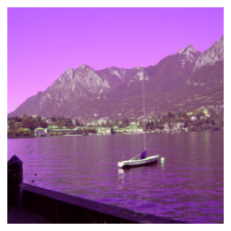

In [39]:
example_img = data[0].cpu().numpy()
example_img_re = recreate_image(example_img, reverse_mean, reverse_std)
plt.imshow(example_img_re)
plt.axis("off")